In [763]:
from loveisland.common.functions import Functions as F
from loveisland.common.constants import RESULTS_4, RESULTS_5

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import re
import pandas as pd
import os
import datetime as dt

from sklearn import linear_model
from sklearn import preprocessing

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.options.mode.chained_assignment = None 

%matplotlib inline
plt.style.use("bmh")

In [467]:
class Arguments():
    def __init__(self, season, bucket="../data/"):
        self.season = season
        self.bucket = bucket

### Predicting the Number of Days an Islander Lasts
For the first part of this analysis we are going try and determine if we can predict the number of days that an islander will last for. There are various ways that islanders are "dumped" from the show, these include being voted off by other islanders, being voted off by the public or by not being in a couple for example, given that the public has a relatively small part to play in the process (even when voting off the contestant the incumbent islanders usually have the final say), therefore the dataset we will be using to train the model is very incomplete. 

In [854]:
class AggAgg:
    def __init__(self, args):
        self.args = args
        self.df = pd.read_csv(
            os.path.join(args.bucket, "season_" + str(args.season), "agg_df.csv")
        )

    @staticmethod
    def date_to_n_lookup(df):
        n_list = list(range(1, df["dumped"].max() + 1))
        d_list = [(df["date"].min() + dt.timedelta(days=n)).date() for n in n_list]
        return pd.DataFrame.from_dict({"dumped": n_list, "dumped_d": d_list})

    def start_end(self):
        if self.args.season == 4:
            sd, ed = "2018-06-04", "2018-07-30"
        else:
            sd, ed = "2019-06-03", "2019-07-30"

        self.df = self.df[(sd <= self.df["date"]) & (self.df["date"] < ed)].reset_index(
            drop=True
        )
        return self

    def islander_agg(self):
        self.df["date"] = pd.to_datetime(self.df["date"])
        self.start_end()
        self.df = self.df.merge(self.date_to_n_lookup(self.df), on="dumped", how="left")
        self.df["dumped_d"] = pd.to_datetime(self.df["dumped_d"])
        self.df = self.df[
            (self.df["date"] <= self.df["dumped_d"]) | (self.df["dumped"] == 0)
        ].reset_index(drop=True)

        self.df = (
            self.df.groupby(["islander", "date"])
            .agg({"n_tweets": "sum", "score": "mean", "favs": "mean"})
            .reset_index()
        )
        self.df["n_tweets_perc"] = self.df.groupby("date")["n_tweets"].apply(
            lambda x: x * 100 / sum(x)
        )
        self.df = (
            self.df.groupby("islander")
            .agg({"n_tweets": "sum", "score": "mean", "n_tweets_perc": "mean", "favs": "mean"})
            .reset_index()
        )

        self.df = self.df.merge(
            F.get_islander_df(self.args.season), on="islander", how="left"
        )
        return self
    
    def create_dummy(self):
        self.df["male"] = np.where(self.df["sex"] == "male", 1, 0)
        return self

    def create_days(self):
        self.df["n_days"] = np.where(
            self.df["dumped"] == 0,
            60 - self.df["arrived"],
            self.df["dumped"] - self.df["arrived"],
        )
        self.df["n_days_perc"] = self.df["n_days"] / (62 - self.df["arrived"])
        return self
    
def normalize(df, ind_cols=["n_tweets_perc", "score"]):
    for col in ind_cols:
        df[col] = preprocessing.normalize([df[col]])[0]
    return df


def fit_mod(df, dep_col="n_days_perc", ind_cols=["n_tweets_perc", "score"]):      
    poly = preprocessing.PolynomialFeatures(degree=2)
    reg = linear_model.LinearRegression()
    
    reg.fit(poly.fit_transform(df[ind_cols]), df[dep_col])
    return reg, poly


def get_stats(df, reg, poly, ind_cols=["n_tweets_perc", "score"]):    
    print("\033[1mRegression outputs", "\033[0;0m")
    print("x0 = n_tweets_perc\nx1 = mean sentiment score\n")
    print("Intercept:", reg.intercept_, "\n") 

    for c in zip(poly.get_feature_names(), reg.coef_):
        if c[0] != '1':
            print("Coefficient for {}: {}".format(c[0], c[1])) 
    print("\nR^2 score:", reg.score(poly.fit_transform(df[ind_cols]), df["n_days_perc"]))


def apply_mod(df, req, poly):
    df["pred"] = df.apply(
        lambda row:reg.predict(poly.fit_transform([[row["n_tweets_perc"], row["score"]]]))[0],
        axis=1)
    df["diff"] = df["n_days_perc"] - df["pred"]
    df["b_o_w"] = np.where(df["diff"] < 0, "worse", "better")
    return df


### Preprocessing 
1. Find mean sentiment score of all tweets about each islander per day, find the percentage of tweets per day that included a direct reference to each islander
2. Filter to only include the days that the islander was in the villa (if an islander left and in reaction to their actions on the outside they may have got a lot of tweets etc, this isn't relevant for predicting something during their time in the villa).
3. Find the mean sentiment score per islander from the days they were in the villa and the mean percentage of tweets about them across all the days they were inside; we want to be "fair" to all islanders, if we simply took the percentage of tweets per all tweets we would be very biased towards islanders who have been their longer, so by taking the average per day, then the average of these, we normalize for islanders who have been on the show for different lengths of times. 
4. Add some metadata to use downstream (islander sex etc)
5. Calculate the proportion of days an islander lasted out of the total number of days they could have stayed. If an islander entered on day 30 and lasted until day 60, then this is only half as many days as someone who entered on day 1 and lasted until day 60, however their available days is half as many so both of these islanders did the best they could and we should account for this - to calculate our dependant variable we shall do: 

`p = (N day the islander left the villa - N day islander entered the villa) / (62 - N day islander entered the villa)`

6. Normalize the independent variables as we know the sentiment score is capped between -1 and 1 with the mean percentage of tweets being uncapped and having a much larger range so normalizing will lead to much more interpretable coefficients.


We will then apply a polynomial regression curve to these features, aiming to predict the proportion of days an islander will stay on the show. My choice to fit a polynomial stems from my assumption that their will be a large interaction between the percentage of tweets an islander receives and the sentiment score behind them, my thinking being that a mid to large percentage of tweets with a positive score will be a better predictor than an huge number of tweets with a score close to zero for example. 




In [915]:
args = Arguments(4)

agg4 = AggAgg(args)
agg4.islander_agg().create_dummy().create_days()

agg_df4 = normalize(agg4.df)
reg, poly = fit_mod(agg_df4)
agg_df4 = apply_mod(agg_df4, reg, poly)
agg_df4.head()

,islander,n_tweets,score,n_tweets_perc,favs,col,sex,relevant,arrived,dumped,season,male,n_days,n_days_perc,pred,diff,b_o_w
0,adam,81346,-0.028408,0.335857,24.007406,#00958B,male,True,1,33,4,1,32,0.524590,0.488218,0.036372,better
1,alex,166048,0.191654,0.416614,23.505778,#E4422D,male,True,1,57,4,1,56,0.918033,0.954266,-0.036234,worse
2,alexandra,29395,0.224181,0.248164,14.770105,#241B23,female,True,39,57,4,0,18,0.782609,0.888062,-0.105453,worse
3,charlie,16662,0.146330,0.099655,15.469293,#96C1C7,male,False,26,43,4,1,17,0.472222,0.613887,-0.141665,worse
4,dani,78705,0.405346,0.199137,25.760649,#D7D5DC,female,True,1,62,4,0,61,1.000000,0.896049,0.103951,better


### Training
Firstly, concentrating on the regression intercept, with 0 tweets and therefore a score of 0 we would expect an islander to last nearly 50% of days they potentially could; this makes sense as to "go the distance" (ie last the maximum number of days) one would expect the islander to be either popular due to being liked (and therefore having a score greater than 0) or get votes due to being entertaining (which based on Love Islander doesn't always mean you're liked!) so therefore would generate a lot of tweets.

Focusing on the coefficients, we see that there is a positive linear relationship between the percentage of tweets an islander receives a day and the number of days an islander stays for, we do see a negative squared term with double the magnitude of the positive linear term which might suggest that this relationship is a parabola and that their is a positive relationship up to a point and then over a certain percentage of tweets the expected number of days on the show begins to reduce. Perhaps counterintuitively, the relationship between mean sentiment score and proportion of days stayed is negative (both the linear and the squared term are negative), this suggests that the more positive the tweets about an islander are, the worse they do on the show, the magnitude of these is both a lot smaller than the coeffitients of the n_tweets_perc variable so clearly score doesn't have as much of an effect as percentage of tweets. 

Considering the interaction term in our model (the coefficient for x*y) we see that this is positive, it is also the largest coefficient by some margin so has the greatest impact on the model, this makes sense as suggests that if an islander receives lots of positive tweets their expected days increases a lot and if they receive a lot of negative tweets then this reduces the expected proportion of days on the show. 

An R^2 term of 0.368 is on the low side of the range (returns a value between 0-100), however given that we are predicting human behaviours this isn't actually too bad! We also know that there will be a lot of noise within the data (due to the nature of sentiment analysis, misspelling on twitter, 

In [916]:
get_stats(agg_df4, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: 0.47148848472938387 

Coefficient for x0: 1.2878213213829288
Coefficient for x1: -0.23943710630046383
Coefficient for x0^2: -3.1252884919370487
Coefficient for x0 x1: 7.242753935840067
Coefficient for x1^2: -1.190052222487162

R^2 score: 0.3679869833835814


Plotting the predicted proportion of days on the show vs the actual number of days on the show we get the following graph. We can see that there is a very positive relationship between the two and without any statistical tests one would say that the model has a pretty good fit. We observe a clustering of islanders who have stayed for nearly the maximum number of days yet are predicted to only last between 50-70% of their maximum number of days - all the islanders in this cluster are the finalists, the majority of them were on the show from the first episode so have a much larger dataset than everyone else, whilst we have tried to normalize for this it does mean that they have a much greater chance of having days with a lot of tweets or with a very low or high sentiment score due to the fact that they were on our screens for so many more days. 

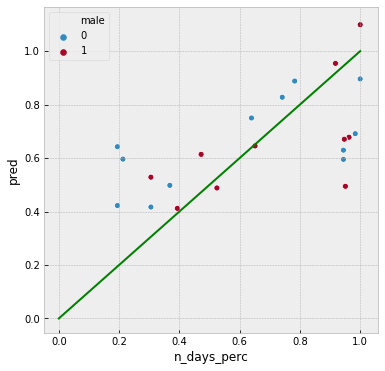

In [921]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("n_days_perc", "pred", "male", data=agg_df4)
sns.lineplot([0,1], [0,1], color="green")

In [918]:
args = Arguments(5)

agg5 = AggAgg(args)
agg5.islander_agg().create_dummy().create_days()
agg_df5 = normalize(agg5.df)

agg_df5 = apply_mod(agg5.df, reg, poly)
agg_df5.head()

,islander,n_tweets,score,n_tweets_perc,favs,col,sex,relevant,arrived,dumped,season,male,n_days,n_days_perc,pred,diff,b_o_w
0,amber,193932,0.158614,0.292568,44.528754,#5D3BAC,female,True,1,0,5,0,59,0.967213,0.848937,0.118276,better
1,amy,108962,0.049867,0.213854,32.348117,#ED4F8A,female,True,1,36,5,0,35,0.573770,0.666302,-0.092532,worse
2,anna,128168,0.090900,0.178376,29.887440,#E4422D,female,True,1,52,5,0,51,0.836066,0.687604,0.148462,better
3,anton,69793,0.135286,0.134493,27.727597,#D7D5DC,male,True,1,0,5,1,59,0.967213,0.665769,0.301444,better
4,arabella,28742,0.016635,0.245171,44.191802,#F7F2F4,female,False,18,25,5,0,7,0.159091,0.624594,-0.465503,worse


### Testing
Given my aim is to predict the winner of Love Island 2019 I want to compare the two series and determine if using last years series as a training set is suitable. In light of this we can use the same model to predict the proportion of potential days an islander will stay in series 5, given the majority have already left we have a lot of validation sources and will be able to determine how good the fit is. 

Focusing on the R-squared term we see a big drop off, this is obviously somewhat expected (one would imagine the model fits worse for testing data compared with the data it was trained one), however the magnitude of the difference is quite large and does suggest that the two series aren't that similar. 

In [919]:
get_stats(agg_df5, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: 0.47148848472938387 

Coefficient for x0: 1.2878213213829288
Coefficient for x1: -0.23943710630046383
Coefficient for x0^2: -3.1252884919370487
Coefficient for x0 x1: 7.242753935840067
Coefficient for x1^2: -1.190052222487162

R^2 score: 0.23072538203520998


Plotting the relationship again is further evidence for a much worse fit. 

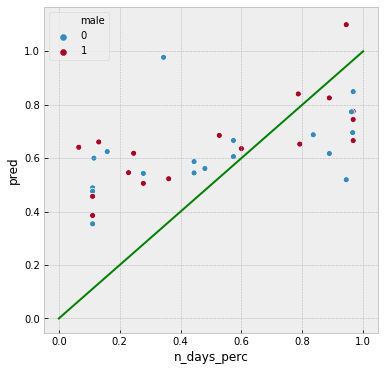

In [920]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("n_days_perc", "pred", "male", data=agg_df5)
sns.lineplot([0,1], [0,1], color="green")

Re-training the model on the data from series 5 we see some interesting differences in the model coefficients, firstly the intercept has decrease dramatically to suggest that an islander with 0 tweets and therefore a 0 score they are expected to last less than 0 days (this is obviously not possible but due to the uncapped nature of the dependent variable it is just a "blind prediction"). We now see both linear terms as positive and a similarly sized interaction effect showing that the sentiment of the tweets combined with the percentage of tweets is still a big predictor. The most notable change is the n_tweets_perc squared term; is very large and negative, this suggests that there is a much stronger relationship between the percentage of tweets per day and the proportion of days an islander stayed on series 5 compared with series 4. 

We see the fit of this model is a lot better than the series 4 model, this could be due to having more data points as we include all the islanders rather than just those that were in couples at the time of voting in series 4. From the graph we again we observe a cluster of finalists that don't fit the model well and also this time a cluster of contestants who entered during Casa Amor and didn't last very long due to not re-coupling, even though the algorithm suggests that they were popular online.  

In [922]:
reg, poly = fit_mod(agg5.df)
agg_df5 = apply_mod(agg5.df, reg, poly)
get_stats(agg_df5, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: -0.054213431793059375 

Coefficient for x0: 6.1394475345961474
Coefficient for x1: 1.6623079964954166
Coefficient for x0^2: -18.914138468277756
Coefficient for x0 x1: 8.527973043886249
Coefficient for x1^2: -5.02625605290406

R^2 score: 0.5482273280906256


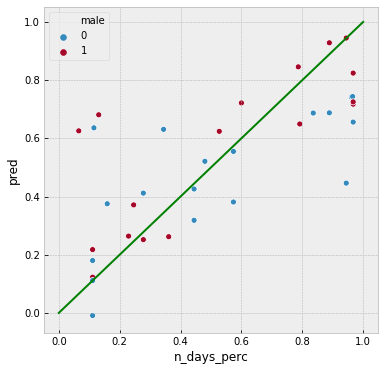

In [923]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("n_days_perc", "pred", "male", data=agg_df5)
sns.lineplot([0,1], [0,1], color="green")

 In conclusion to this first part on predicting the number of potential days each individual islander lasts, we see that we can produce fairly good models using the mean percentage of tweets than mention each islander per day combined with the mean sentiment score per day. We have seen that there are notable differences between series 4 and 5, notably the increase in importance between the relationship between percentage of tweets per day and number of days on the show. To improve these models we could use more features about the individuals, such as sex, ethnicity and age for example, however I did this to compare the features we used to determine if we could use season 4 data to compare couples, which means we wouldn't be able to use these due to complexity and a very small sample size. 

### Predicting the Winner 

In [10]:
class PredCommon:
    def __init__(self, df):
        self.agg_df = pd.DataFrame()
        self.df = df
            
    def recode_col(self, sdate, edate, d_col):
        self.df["vote"] = np.where(
            (sdate <= self.df[d_col]) & (self.df[d_col] < edate), edate, self.df["vote"],
        )
        return self
    
    def recode_vote(self, d_col="date"):
        if self.args.season == 4:
            dl = ["2018-06-26", "2018-07-04", "2018-07-13", "2018-07-20", "2018-07-24", "2018-07-29"]
        else:
            dl = ["2019-06-26", "2019-07-07", "2019-07-12", "2019-07-19", "2019-07-23", "2019-07-30"]
        
        self.df["vote"] = np.where(self.df[d_col] < dl[0], dl[0], "else")
        for i in range(len(dl)-1):
            self.recode_col(dl[i], dl[i+1], d_col)
        
    def get_totals(self, gb=["vote"]):
        return self.do_agg(gb)[gb + ["n_tweets", "n_users"]].rename(
            columns={"n_tweets": "n_tweets_total", "n_users": "n_users_total"}
        )

    def get_perc(self, col):
        self.agg_df[col + "_perc"] = (
            self.agg_df[col] * 100 / self.agg_df[col + "_total"]
        )
        return self

In [11]:
class AggCouples(PredCommon):
    def __init__(self, args, df):
        PredCommon.__init__(self, df)
        self.args = args

        self.results = self.get_results()
        self.comb = self.get_couples(self.results)

        self.format_res()
        self.recode_vote()
        
    def get_results(self):
        if self.args.season == 4:
            return RESULTS_4
        else:
            return RESULTS_5

    @staticmethod
    def get_couples(results):
        comb = []
        [comb.extend(list(v.keys())) for k, v in results.items()]
        comb = list(set(comb))
        return comb

    def format_res(self):
        recode = {}
        for k0, v0 in self.results.items():
            recode[k0] = {}
            for k1, v1 in self.results[k0].items():
                recode[k0][k1[0] + "_" + k1[1]] = v1
        self.results = recode
        return self

    @staticmethod
    def format_pair(pair):
        pair = [i.lower() for i in pair]
        return pair, pair[0] + "_" + pair[1]

    def do_agg(self, gb=["vote"], ph=None):
        """Aggregate various metrics per couple/date"""
        AGG_JS = {
            "favs": "mean",
            "retwe": "mean",
            "score": "mean",
            "user": "nunique",
            "url": "count",
            "weight_senti": "mean",
        }
        RN_JS = {"url": "n_tweets", "user": "n_users"}

        df = self.df[self.df["score"] != 0]
        if ph is not None:
            df = df[df[ph] == ph]
            gb = gb + [ph]
            RN_JS[ph] = "couple"
        if len(df) > 0:
            return df.groupby(gb).agg(AGG_JS).reset_index().rename(columns=RN_JS)
        return pd.DataFrame()

    def get_agg_df(self):
        for pair in self.comb:
            pair, ph = self.format_pair(pair)
            if pair[0] in self.df.columns and pair[1] in self.df.columns:
                self.df[ph] = np.where(
                    (self.df[pair[0]] == pair[0]) & (self.df[pair[1]] == pair[1]),
                    ph,
                    "nan",
                )

                self.agg_df = self.agg_df.append(
                    self.do_agg(["vote"], ph), sort=True
                ).reset_index(drop=True)

        self.agg_df = self.agg_df.merge(self.get_totals(), on="vote", how="left")
        self.get_perc("n_tweets")
        self.get_perc("n_users")
        return self

    @staticmethod
    def get_split(x, n):
        return x.split("_")[n]

    def add_islanders(self):
        self.agg_df["female"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 0)
        )
        self.agg_df["male"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 1)
        )
        return self

    def get_res(self):
        res = pd.DataFrame.from_dict(self.results).reset_index()
        res = pd.melt(
            res, id_vars=["index"], value_vars=[c for c in res.columns if c != "index"]
        )
        res = res.rename(
            columns={"variable": "vote", "value": "v_share", "index": "couple"}
        )
        res["couple"] = res["couple"].str.lower()
        res["v_max"] = res.groupby(["couple", "vote"])["v_share"].transform(max)
        return (
            res[res["v_max"] == res["v_share"]]
            .drop(columns=["v_max"])
            .reset_index(drop=True)
        )

    def full_df(self):
        self.add_islanders()

        self.agg_df = self.agg_df.merge(
            self.get_res(), on=["vote", "couple"], how="left"
        )
        self.agg_df = self.agg_df[
            (self.agg_df["n_tweets_perc"].notna()) & 
            (self.agg_df["score"].notna()) & 
            (self.agg_df["v_share"].notna()
            )]
        return self


In [882]:
def get_btn(df):
    tmp = df[df["v_share"] != 1]
    tmp = tmp.groupby(["vote"])["v_share"].agg({"btm": 'count', "v_max":'max'}).reset_index()
    tmp["btm"] = tmp["btm"] / tmp["v_max"]
    return df.merge(tmp, on="vote", how="left")

def get_predictions(reg, df):
    df["pred_v_share"] = df.apply(
        lambda row:reg.predict(poly.fit_transform([[row["n_tweets_perc"], row["score"]]]))[0],
        axis=1
    )
    df["pred_order"] = df.sort_values(by="pred_v_share", ascending=False).groupby("vote").cumcount() + 1
    return get_btn(df)

def validate(df):
    df["rev_order_true"] = df.sort_values(by="v_share", ascending=True).groupby("vote").cumcount() + 1
    df["order_true"] = df.sort_values(by="v_share", ascending=False).groupby("vote").cumcount() + 1
    
    df = df[df["rev_order_true"] <= 2]    
    cols = ["vote", "couple", 'n_tweets_perc', 'score', "v_share", "order_true","pred_v_share", "pred_order"]
    return df[df["order_true"] != df["pred_order"]][cols].sort_values("vote").reset_index(drop=True)
    

def find_accuracy(df):
    df["pos"] = df["pred_order"] / df["v_max"]
    
    df["true_bottom"] = np.where(df["v_share"] == 1.0, True, False)
    df["pred_bottom"] = np.where(df["pos"] > df["btm"], True, False)
    
    cols = ["vote", "couple", 'n_tweets_perc', 'score', "true_bottom", "pred_bottom", "pred_v_share", "pred_order"]
    return df[df["pred_bottom"] != pred_df["true_bottom"]][cols].sort_values("vote").reset_index(drop=True)


In [887]:
args = Arguments(4)

df = F.import_all(
    os.path.join(args.bucket, "season_" + str(args.season), "processed/")
)
fd4 = AggCouples(args, df)
fd4.get_agg_df().full_df()

In [948]:
req, poly = fit_mod(normalize(fd4.agg_df), dep_col='v_share')

In [949]:
pred_df = get_predictions(req, normalize(fd4.agg_df))
validate(pred_df)

/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,vote,couple,n_tweets_perc,score,v_share,order_true,pred_v_share,pred_order
0,2018-06-26,megan_eyal,0.133466,-0.014047,2.80,5,-1.548651,6
1,2018-06-26,zara_adam,0.053825,-0.006679,2.40,6,3.839035,5
2,2018-07-04,ellie_sam,0.009468,0.047466,0.30,8,5.569304,4
3,2018-07-04,darylle_adam,0.006618,0.129296,1.20,7,3.859369,5
4,2018-07-20,steph_josh,0.002535,0.064713,0.90,6,5.420999,4
5,2018-07-29,kaz_josh,0.240263,0.214643,6.05,3,40.537968,2
6,2018-07-29,laura_paul,0.174597,0.173236,8.43,2,17.936171,3


/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


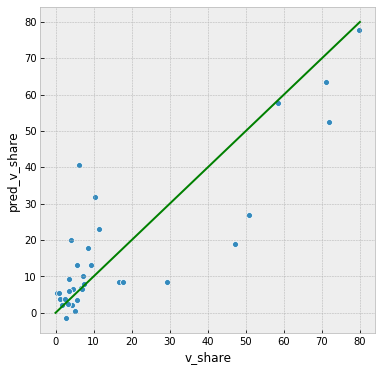

In [950]:
pred_df = get_predictions(req, normalize(fd4.agg_df))
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("v_share", "pred_v_share", data=pred_df)
sns.lineplot([0,80], [0,80], color="green")
# sns.lineplot([0,80], [0,80*req.score(fd4.agg_df[['n_tweets_perc', 'score']], fd4.agg_df['v_share'])], color="red")

In [892]:
args = Arguments(5)

df = F.import_all(
    os.path.join(args.bucket, "season_" + str(args.season), "processed/")
)
fd5 = AggCouples(args, df)
fd5.get_agg_df().full_df()

In [951]:
pred_df = get_predictions(req, normalize(fd5.agg_df))
find_accuracy(pred_df)

/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,vote,couple,n_tweets_perc,score,true_bottom,pred_bottom,pred_v_share,pred_order
0,2019-06-26,amy_curtis,0.131518,0.154605,True,False,9.508994,2
1,2019-06-26,molly_tommy,0.147715,0.057492,False,True,1.148924,6
2,2019-07-07,joanna_michael,0.114409,-0.009730,False,True,-0.747924,8
3,2019-07-07,amy_curtis,0.411474,0.038912,True,False,39.204088,2
4,2019-07-07,lucie_george,0.015962,0.034763,True,False,5.570227,5
5,2019-07-07,belle_anton,0.020479,0.172867,False,True,4.829391,6
6,2019-07-19,michael_francesca,0.004566,0.237248,True,False,8.535610,3
7,2019-07-19,belle_anton,0.162971,-0.009144,False,True,-2.003911,6
8,2019-07-23,anna_jordan,0.293098,0.047476,True,False,14.893627,4
9,2019-07-23,belle_anton,0.061612,0.212261,False,True,9.877501,6


In [952]:
from sklearn.metrics import f1_score, accuracy_score
# from sklearn.metrics import multilabel_confusion_matrix

print("Model Accuracy:", accuracy_score(pred_df["true_bottom"], pred_df["pred_bottom"]))
print("Model F1 Score:", f1_score(pred_df["true_bottom"], pred_df["pred_bottom"]))

Model Accuracy: 0.7142857142857143
Model F1 Score: 0.5833333333333334
